<a href="https://colab.research.google.com/github/Squiro/droidAmp/blob/master/HPC/Ejecicios/Sinopoli_Alesio_ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introducción**

El siguiente ejercicio tiene como objetivo realizar una comparación entre la ejecución secuencial y paralela del algoritmo de la Regla del Trapecio.

La Regla del Trapecio [1] [2] [3] es una técnica relacionada al Cálculo Númerico, la cual nos permite calcular aproximadamente el valor de una integral definida. Generalmente, cuando uno hace mención de esta regla, hace referencia a la Regla del Trapecio Compuesta, la cual permite aproximar la integral utilizando N trapecios. En este ejercicio se implementa dicha regla, utilizando una división en N trapecios del mismo tamaño.

Pertenece a la familia de fórmulas Newton–Cotes, que, si bien posee métodos que convergen con mayor rapidez, la Regla del Trapecio suele converger más rápidamente en curvas que no sean suaves. [4]

La aproximación de esta regla se vuelve más precisa a medida que N sea más grande.

La fórmula que representa esta regla, bajo las condiciones nombradas anteriormente, es:

\begin{equation}
\int _{a}^{b}f(x)\,dx\approx {\displaystyle {}={\frac {\Delta x}{2}}\left(f(x_{0})+f(x_{N})+2\sum _{k=1}^{N-1}f(x_{k})\right)}
\end{equation}

**Explicación de la regla**

Dada la integral definida de una función f(x) en un intervalo [a,b]

\begin{equation}
\int_a^b f(x) \; dx
\end{equation}

Se realiza una división del intervalo [a,b] en N intervalos del mismo tamaño h, siendo $h = (b-a)/n$. Para cada intervalo, se toma el trapecio formado por el segmento vertical de $f(x_i)$, el segmento vertical de 0 a $f(x_{i+1})$ y el segmento que une $f(x_i)$ con $f(x_{i+1})$. La suma de las áreas de todos esos trapecios es una aproximación al área que hay debajo de dicha curva.

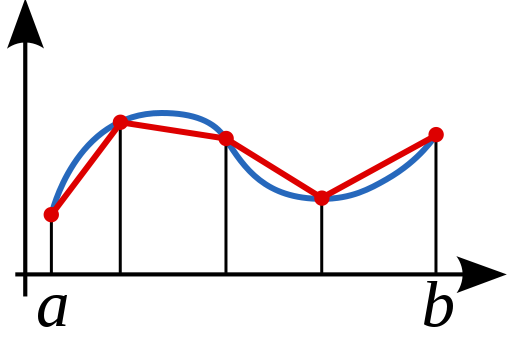

**Algoritmo y objetivo del ejercicio**

Este ejercicio implementa un algoritmo para calcular la integral definida a través de la Regla del Trapecio Compuesta. El algoritmo es bastante sencillo: consiste en un ciclo for que realiza una sumatoria.

Sin embargo, dependiendo de la cantidad de N intervalos, el algoritmo podría presentar una mejora al realizar las iteraciones del ciclo for en paralelo, en vez de secuencialmente. De esta forma, implementamos dos versiones del algoritmo: una secuencial, y una paralela utilizando la API OpenMP para la creación de hilos que serán ejecutados concurrentemente.

Se buscará comparar si realmente existe una ventaja al realizar esta implementación en paralelo a través de OpenMP.


## **2. Armado del ambiente**
### **2.1 Seteo de parámetros**

En este punto el lector podrá indicar la función sobre la cual realizar la integración. Es importante notar que la función ingresada debe respetar el formato de algebraico utilizado en C, ya que dicha función será inyectada en el código antes de compilar el mismo.

Le recomendamos al lector que tenga especial cuidado al ingresar la función, ya que si la misma contiene errores de sintaxis según el lenguaje C, el programa no podrá ser compilado.

In [ ]:
funcion = "1/(x+1) + (39*x)/(x+2) + x*x*x - (43*x*x)" #@param {type:"string"}

### **2.2 Generación del archivo .c que contendrá el código**

Debido a que OpenMP no tiene soporte en lenguaje Python, necesitamos crear un archivo .c el cual contendrá el código del programa, ya que C es uno de los lenguajes que posee soporte de OpenMP a través de la biblioteica omp.h. 

Posteriormente compilaremos este archivo en un ejecutable con el compilador gcc de Linux, el cual permitirá ejecutar el programa en este notebook.

In [ ]:
code = """
#include <sys/time.h>
#include <omp.h>
#include <stdio.h>
#include <stdlib.h>
#include <float.h>
#include <limits.h>
#include <errno.h>

//-------------------------------
// Macros que miden el tiempo
static double dHashTiempoHistory[3];
static struct timeval tv;

#define TIEMPO_INI(h) \
  gettimeofday(&tv, NULL); \
  dHashTiempoHistory[h] = tv.tv_sec + tv.tv_usec/1000000.0;

#define TIEMPO_FIN(h) \
  gettimeofday(&tv, NULL); \
  dHashTiempoHistory[h] = ((tv.tv_sec + tv.tv_usec/1000000.0) - dHashTiempoHistory[h]) * 1000;

#define TIEMPO_GET(h) dHashTiempoHistory[h]
#define HTH_TOTAL 1
#define HTH_INTEGRAL_SEC 2
#define HTH_INTEGRAL_OMP 3

int main(int argc, char * argv[]);
double f(double x);
double integracionPorTrapecioOMP(double a, double b, int n);
double integracionPorTrapecioSEC(double a, double b, int n);
int stringToInt(char *str);
double stringToDouble(char *str);

int main(int argc, char * argv[])
{
  TIEMPO_INI(HTH_TOTAL);

  if (argc != 4)
  {
    fprintf(stderr, \"Se recibieron menos parámetros de los requeridos.\\n\");
    fprintf(stderr, \"PARÁMETROS: \\n\");
    fprintf(stderr, \"a: Punto a desde donde se calculará la integral de la función.\\n\");
    fprintf(stderr, \"b: Punto b hasta donde se calculará la integral de la función.\\n\");
    fprintf(stderr, \"n: Cantidad subdivisiones en intervalos.\\n\");
    exit(-1);
  }

  double a = stringToDouble(argv[1]);
  double b = stringToDouble(argv[2]);
  int n = stringToInt(argv[3]);

  if (n <= 0)
  {
    fprintf(stderr, \"ERROR: el parametro N tiene que ser mayor a cero. \\n\");
    exit(-1);
  }

  TIEMPO_INI(HTH_INTEGRAL_SEC);
  integracionPorTrapecioSEC(a, b, n);
  TIEMPO_FIN(HTH_INTEGRAL_SEC);

  TIEMPO_INI(HTH_INTEGRAL_OMP);
  double resultado = integracionPorTrapecioOMP(a, b, n);
  TIEMPO_FIN(HTH_INTEGRAL_OMP);

  //----------------------------  
  // Resultados

  printf(\"El resultado de la integración es: %f \\n\", resultado);

  TIEMPO_FIN(HTH_TOTAL);
  printf(\"Tiempo TOTAL: %f ms\\n\", TIEMPO_GET(HTH_TOTAL));
  printf(\"Tiempo SEC: %f ms\\n\", TIEMPO_GET(HTH_INTEGRAL_SEC));
  printf(\"Tiempo OMP: %f ms\\n\", TIEMPO_GET(HTH_INTEGRAL_OMP));
  printf(\"\\n\");
  printf(\"SpeedUp: (tiempo sec/tiempo paralelo) %f\\n\", (TIEMPO_GET(HTH_INTEGRAL_SEC)/TIEMPO_GET(HTH_INTEGRAL_OMP)));
  printf(\"Eficiencia: speedup/nro_procesadores = %f\\n\", ((TIEMPO_GET(HTH_INTEGRAL_SEC)/TIEMPO_GET(HTH_INTEGRAL_OMP))/omp_get_num_procs()));
  printf(\"Coste Sec: nro_procesadores*Tiempo = %f\\n\", (TIEMPO_GET(HTH_INTEGRAL_SEC)*omp_get_num_procs()));
  printf(\"Coste OMP: nro_procesadores*Tiempo = %f\\n\", (TIEMPO_GET(HTH_INTEGRAL_OMP)*omp_get_num_procs()));
  printf(\"Function Overhead: coste_omp - tiempo sec = %f\\n\", (TIEMPO_GET(HTH_INTEGRAL_OMP)*omp_get_num_procs())-TIEMPO_GET(HTH_INTEGRAL_SEC));
}

double stringToDouble(char * str) 
{
  double lnum;
  double num;
  char *end;

  errno = 0;

  lnum = strtol(str, &end, 10);   
  if (end == str)  
      fprintf(stderr, \"ERROR: no se pudo convertir el string a un numero\\n\");

  if ((lnum > DBL_MAX  || lnum < DBL_MIN ) && errno == ERANGE)
      fprintf(stderr, \"ERROR: numero fuera de rango para DOUBLE\\n\");

  num = (double) lnum;

  return num;
}


int stringToInt(char * str)
{
  long lnum;
  int num;
  char *end;

  errno = 0;

  lnum = strtol(str, &end, 10);   
  if (end == str)    
      fprintf(stderr, \"ERROR: no se pudo convertir el string a un numero\\n\");

  if ((lnum == LONG_MAX || lnum == LONG_MIN) && errno == ERANGE)
      fprintf(stderr, \"ERROR: numero fuera de rango para LONG\\n\");
  
  if ( (lnum > INT_MAX) || (lnum < INT_MIN) )
      fprintf(stderr, \"ERROR: numero fuera de rango para INT\\n\");

  num = (int) lnum;

  return num;
}

double integracionPorTrapecioOMP(double a, double b, int n)
{
    double h = (b-a)/n;
    double sumatoria = 0;

    #pragma omp parallel for reduction(+: sumatoria)
    for (int i = 1; i < n; i++)
    {
        sumatoria += f(a+i*h);
    }

    return sumatoria = (f(a) + f(b) + 2 * sumatoria)*(h/2);
}

double integracionPorTrapecioSEC(double a, double b, int n)
{
    double h = (b-a)/n;
    double sumatoria = 0;
    
    for (int i = 1; i < n; i++)
    {
        sumatoria += f(a+i*h);
    }

    return sumatoria = (f(a) + f(b) + 2 * sumatoria)*(h/2);
}


"""

func = """
double f(double x)
{
  return
"""

try: 
  final_code = code + func + funcion + "; }"
except Exception as e:
  print("Hubo un error al inyectar la funcion. Asegurese de ejecutar el paso anterior.")
  raise

textfile = open("code_integral_trapecio.c", "w");
textfile.write(final_code)
textfile.close()

### **2.3 Compilación del código**

En este paso se compila el código en un ejecutable, debido a lo mencionado en el punto 2.2.

In [ ]:
!gcc -o integral_trapecio -fopenmp code_integral_trapecio.c

## **3. Desarrollo**
Ejecución del programa. El lector puede variar los argumentos enviados a su gusto, para calcular la integral definida en el intervalo [a, b] de su preferencia. También puede indicar la cantidad de subdivisiones en intervalos a realizar.

También puede especificar la cantidad de hilos utilizada por OpenMP para la ejecución paralela del algoritmo al cambiar el valor de la variable de entorno OMP_NUM_THREADS.

**Parámetros**

El programa acepta los siguientes parámetros, en el correspondiente orden:

1. **a:** Punto a desde donde se calculará la integral de la función.

2. **b:** Punto b hasta donde se calculará la integral de la función.

3. **n:** Cantidad subdivisiones en intervalos.

In [ ]:
%env OMP_NUM_THREADS=4
!./integral_trapecio 12 736 50000

env: OMP_NUM_THREADS=4
El resultado de la integración es: 67644154976.741982 
Tiempo TOTAL: 3.103018 ms
Tiempo SEC: 1.046181 ms
Tiempo OMP: 1.971960 ms

SpeedUp: (tiempo sec/tiempo paralelo) 0.530528
Eficiencia: speedup/nro_procesadores = 0.265264
Coste Sec: nro_procesadores*Tiempo = 2.092361
Coste OMP: nro_procesadores*Tiempo = 3.943920
Function Overhead: coste_omp - tiempo sec = 2.897739


## **4. Tabla de pasos**

| Procesador | Función               | Detalle                                                                                                               |
|------------|-----------------------|-----------------------------------------------------------------------------------------------------------------------|
| CPU        | funcion = "..."           | Setea la función usada para calcular la integral definida.                                                   |
| CPU        | code = """       | Declara un string literal en Python, el cual contiene el código en lenguaje C.                                                                 |
| CPU        | textfile.open()       | Abre y crea un nuevo archivo en el cual se escribirá el código.                                                                 |
| CPU        | textfile.write()       | Escribe el string literal con el código en lenguaje C en el archivo.                                                             |
| CPU        | !gcc -o integral_trapecio                | Compila el archivo de código C en un programa ejecutable.                                                     |
| CPU        | !./integral_trapecio <param>       | Ejecución del programa.                                  |
| CPU        | TIEMPO_INI(HTH_INTEGRAL_TOTAL)    | Toma el tiempo actual del comienzo de ejecución del programa. |
| CPU        | stringToDouble    | Convierte los parámetros a y b a un número del tipo double. |
| CPU        | stringToInt    | Convierte el parámetro n a un número del tipo int. |
| CPU        | TIEMPO_INI(HTH_INTEGRAL_SEC)    | Toma el tiempo actual del comienzo de ejecución del algoritmo secuencial. |
| CPU        | integracionPorTrapecioSEC()   | Ejecución del algoritmo secuencial. |
| CPU        | TIEMPO_FIN(HTH_INTEGRAL_SEC)    | Toma el tiempo actual de la finalización de ejecución del algoritmo secuencial. |
| CPU        | TIEMPO_INI(HTH_INTEGRAL_OMP)    | Toma el tiempo actual del comienzo de ejecución del algoritmo en paralelo. |
| CPU        | integracionPorTrapecioOMP()   | Ejecución del algoritmo en paralelo. |
| CPU        | #pragma omp parallel for reduction(+: sumatoria)  | Directiva del compilador, que indica que el ciclo for se ejecutará en paralelo. Se utiliza una reducción de suma, a fin de evitar condiciones de carrera en la variable compartida sumatoria. |
| CPU        | TIEMPO_FIN(HTH_INTEGRAL_OMP)    | Toma el tiempo actual de la finalización de ejecución del algoritmo en paralelo. |
| CPU        | TIEMPO_FIN(HTH_INTEGRAL_TOTAL)    | Toma el tiempo actual de finalización de ejecución del programa. |
| CPU        | printf(...)    | Impresión por pantalla de resultados y estadísticas. |

## **5. Conclusiones**

### **Breve repaso**

La Regla del Trapecio es una técnica del Cálculo Númerico utilizado para aproximar la integral definida de una función continua en un intervalo [a, b]. La misma, como su nombre lo indica, aproxima el área debajo de la curva al dividir la misma en N trapecios, a los cuales se les cálcula su área, realizándose por último una sumatoria de los mismos para obtener la integral definida aproximada.

En este ejercicio se realizó una implementación del algoritmo de la Regla del Trapecio, utilizando tanto programación secuencial (un solo hilo) como ejecución paralela a través de la API OpenMP. Tanto la ejecución secuencial como paralela se realizan por sobre un CPU.

### **Resultados**

Se realizaron dos pruebas de este algoritmo, a fines de obtener resultados que reflejen el rendimiento del mismo.

1. **Primera prueba**

Se ejecutó el programa con la siguiente función:
\begin{equation}
x*x + x*x*x + 23*x - x*2
\end{equation}

Y con los siguientes parámetros:

1. **a:** -121

2. **b:** 600

3. **n:** 25000

4. **Número de threads:** 2 

El resultado arrojado por el ejecutable fue de: 32422627141.495949 

Si ejecutamos esta integral definida en Symbolab, obtenemos como resultado lo siguiente: 32422627069.58333

Podemos notar que la aproximación realizada por nuestro algoritmo comienza a diferir a partir del noveno dígito. Teniendo en cuenta que estamos calculando una integral definida de un intervalo demasiado amplio, este margen de error no resulta ser tan grande.

2. **Segunda prueba**

Se ejecutó el programa con la siguiente función:
\begin{equation}
1/(x+1) + x*x + (39*x)/(x+2) + x*x*x - (43*x*x)
\end{equation}

Y con los siguientes parámetros:

1. **a:** 12 

2. **b:** 736 

3. **n:** 50000

4. **Número de threads:** 4 

El resultado arrojado por el ejecutable fue de: 67644154976.741997   
 
Si ejecutamos esta integral definida en Symbolab, obtenemos como resultado lo siguiente: 6764415494.944315

Nuevamente la precisión de nuestro algoritmo resulta ser bastante aceptable, considerando que el trapecio es una aproximación de la integral definida, y sabiendo que existen mejores métodos para aproximar el área debajo de una curva.

### **Comparaciones**

Para realizar las comparaciones entre las distintas pruebas, utilizamos las siguientes métricas:

### Tiempo TOTAL

Tiempo total de ejecución del programa. 

### Tiempo SEC

Tiempo de ejecución del algoritmo secuencial.

### Tiempo OMP

Tiempo de ejecución del algoritmo paralelo a través de OpenMP.

### SpeedUp

Referencia a la ganancia de velocidad que se consigue con un algoritmo paralelo al resolver el mismo problema respecto a un algoritmo secuencial.

\begin{equation}
SpeedUp = TiempoSec/TiempoParalelo
\end{equation}

### Eficiencia

La eficiencia normaliza el valor del SpeedUp, al dividirlo por la cantidad de procesadores que se utilizaron para alcanzar la ganancia de velocidad, dando la idea de la porción de tiempo que los procesadores dedicaron al trabajo útil.

\begin{equation}
Eficiencia = SpeedUp/Nro.procesadores
\end{equation}

### Coste

El coste de un algoritmo representa el tiempo realizado por todo el sistema en la resolución del problema.

\begin{equation}
Coste = Nro.procesadores*TiempoAlgoritmo
\end{equation}

### Función Overhead

Es la diferencia entre el Coste y el Tiempo secuencial. Mientras mayor es la función overhead, peor es el comportamiento del algoritmo. paralelo.

\begin{equation}
Overhead = Coste-TiempoSecuencial
\end{equation}

### **Resultados de la primera prueba**

*   **Tiempo TOTAL:** 1.767874 ms

*   **Tiempo SEC:** 0.374079 ms

*   **Tiempo OMP:** 1.348972 ms

*   **SpeedUp:** 0.277306

*   **Eficiencia:** 0.138653

*   **Coste Sec:** 0.748158

*   **Coste OMP:** 2.697945

*   **Function Overhead:** 2.323866

Podemos notar que el algoritmo ejecutado en paralelo tiene un pésimo desempeño. Ninguna de las métricas devuelve un resultado favorable para el mismo: tanto el SpeedUp como la Eficiencia  indican que el algoritmo ejecutado en paralelo tiene un tiempo de ejecución mayor, mientras que el Coste OMP indica que se gastó el triple de recursos para ejecutar el algoritmo en paralelo que en secuencial. 

### **Resultados de la segunda prueba**

*   **Tiempo TOTAL:** 3.103018 ms

*   **Tiempo SEC:** 1.046181 ms

*   **Tiempo OMP:** 1.971960 ms

*   **SpeedUp:** 0.530528

*   **Eficiencia:** 0.265264

*   **Coste Sec:** 2.092361

*   **Coste OMP:** 3.943920

*   **Function Overhead:** 2.897739

Nuevamente notamos que la ejecución secuencial resulta ser mejor que la paralela, sin embargo los resultados obtenidos por el algoritmo paralelo presentan una leve mejoría respecto a aquellos de la primera prueba.


### **Sugerencias**

El algoritmo para la Regla del Trapecio es un algoritmo simple, que quizás no justifique su paralelización, ya que un CPU podría realizar las iteraciones y cálculos secuencialmente en un tiempo más que aceptable. Sin embargo, existen muchos otros algoritmos pertenecientes al Cálculo Númerico que realizan cálculos más complejos o necesitan una cantidad mayor de iteraciones para arrojar resultados con menor error.

Debido a esto, sería interesante comprobar si la paralelización de algoritmos más complejos presenta una mejora respecto a la ejecución secuencial de los mismos. Sin embargo, es posible que muchos de estos algoritmos no puedan realizarse en paralelo, o que su ejecución en paralelo se vea afectada debido a la necesidad de sincronización entre los diferentes pasos.

De todas formas, existen varias posibilidades de expander y mejorar este ejercicio para obtener un mejor panorama acerca del rendimiento que ofrece OpenMP en cuanto a la paralelización con hilos de CPU. El algoritmo utilizado podría mejorarse de varias formas, por ejemplo, diviendo el ciclo for en N ciclos for que se ejecuten en paralelo. De esta forma, cada hilo tendrá un ciclo for que ejecutará de principio a fin, y estos ciclos for presentarán una cantidad menor de iteraciones.

### **Lecciones aprendidas**

Los resultados que obtuvimos en ambas comparaciones aparentan ser desfavorables para la ejecución paralela de este algoritmo. Sin embargo, debemos considerar que dichas ejecuciones están siendo realizadas sobre un entorno virtual (el proveído por Google Colab), sobre un CPU al que no tenemos acceso a toda la cantidad de hilos que el mismo posea.

Esto resulta perjudicial para el algoritmo en paralelo, ya que si, por ejemplo tuvieramos acceso solamente a 2 hilos de ejecución, esos dos hilos tendrán que dividirse la cantidad de iteraciones del ciclo for. Esto implica hacer muchos cambios de contexto, provocando una ralentizando de la ejecución del algoritmo en su totalidad.

Sin embargo, aunque no tuviésemos las restricciones impuestas por el entorno virtual, es posible que no notemos un rendimiento favorable en un CPU con mayor cantidad de hilos: ninguno de los CPU de hoy en día posee una gran cantidad de hilos que pueda ejecutar paralelamente al mismo tiempo, por ejemplo, la cantidad de iteraciones del for utilizadas en la Primera Prueba. En cambio, las GPU poseen una mayor cantidad de hilos de ejecución en paralelo, por lo que si ejecutaramos este algoritmo en una, podríamos llegar a notar una diferencia favorable.

Podemos concluir que OpenMP facilita la ejecución de algoritmos en paralelo. El hecho de poder utilizar una directiva del compilador para paralelizar una sección de nuestro código es algo extremadamente simple, en comparación con todas las pautas y métodos que hay que seguir para ejecutar algoritmos en paralelo en una GPU. En OpenMP no tenemos que preocuparnos por definir una función kernel, ni de copiar áreas de memoria. 

Sin embargo esta simplicidad viene acompañada con la desventaja nombrada anteriormente: los CPUs no poseen la misma capacidad que las GPUs para realizar ejecuciones en paralelo, por lo que inherentemente la ejecución en paralelo en un CPU será peor en aquellos casos donde tengamos una gran cantidad de hilos a ejecutar.

## **6. Bibliografía**

[1] Yeh, Shi-Tao. (2002). Using trapezoidal rule for the area under a curve calculation. Proceedings of the 27th Annual SAS® User Group International (SUGI’02). [En línea] Disponible en: https://www.lexjansen.com/nesug/nesug02/ps/ps017.pdf

[2] Burden, Richard L.; Faires, J. Douglas (2000), Numerical Analysis (7th ed.), Brooks/Cole, ISBN 978-0-534-38216-2

[3]  Rahman, Q. I., & Schmeisser, G. (1990). Characterization of the speed of convergence of the trapezoidal rule. Numerische Mathematik, 57(1), 123-138. [En Línea] Disponible en: https://link.springer.com/article/10.1007%2FBF01386402

[4] Cruz-Uribe, D.; Neugebauer, C. J. (2002), "Sharp Error Bounds for the Trapezoidal Rule and Simpson's Rule", Journal of Inequalities in Pure and Applied Mathematics. [En línea] Disponible en: http://www.emis.de/journals/JIPAM/images/031_02_JIPAM/031_02.pdf
